# Vector Quantization Demo by Joe Everton

Adapted from CS 498, Applied Machine Learning, taught by Trevor Walker and developed by D. A. Forsyth.  You can find the textbook for that course, [here](http://luthuli.cs.uiuc.edu/~daf/courses/AML-18-Fall/AMLbook-3-Dec-18.pdf) (section 9.3)

Using the ADL dataset, available [here](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer#).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
import os
import ntpath
# https://stackoverflow.com/questions/8384737/extract-file-name-from-path-no-matter-what-the-os-path-format
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def load_data():
  dataset = []
  labels = []
  label_index = 0
  for dirname, dirnames, filenames in os.walk('HMP_Dataset'):
      # target all leaf directories not ending with '_MODEL'.
      if len(dirnames) == 0 and '_MODEL' not in dirname:
        class_name = path_leaf(dirname)
        labels.append(class_name)
        for filename in filenames:
            dataset.append((np.loadtxt(os.path.join(dirname, filename)), label_index))
        label_index += 1
  return dataset, labels

In [3]:
# from https://stackoverflow.com/questions/15722324/sliding-window-in-numpy
def window_stack(a, stepsize, width):
  n = a.shape[0]
  return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

def get_flattened_data(data, stepsize, width):
  flattened_data = window_stack(data[0][0], stepsize, width)
  for i in range(1, len(dataset)):
    slices = window_stack(data[i][0], stepsize, width)
    flattened_data = np.concatenate((flattened_data, slices), axis=0)
  return flattened_data

In [4]:
class h_kmeans:
  n_jobs = -1
  def __init__(self, n_clusters, n_jobs=-1):
    # n_clusters is a vector of K for each depth.  The depth of the tree == length of n_clusters.
    if type(n_clusters) != tuple:
      # if given a non-tuple (int) make it a tuple.
      n_clusters = (n_clusters,)
    h_kmeans.n_jobs = n_jobs
    self.my_k = n_clusters
    # print ("Initializing KMeans, n_clusters = {}".format(self.my_k[0]))
    self.km = KMeans(n_clusters=self.my_k[0], n_jobs=h_kmeans.n_jobs)
    self.children = []
    if len(n_clusters) > 1:
      # Remove my k, pass the rest to the children.
      self.children = [h_kmeans(n_clusters[1:]) for km in range(self.my_k[0])]
      # self.children = [h_kmeans(n_clusters[1:])] * self.my_k[0]

  def fit(self, X):
    if len(X) > 5000 and len(self.children) > 0:
      rand_indexes = np.random.randint(len(X), size=5000)
      self.km.fit(X[rand_indexes])
    else:
      self.km.fit(X)
    if len(self.children) > 0:
      clusters = self.km.predict(X)
      # print("fitting children with row count:", end='')
      for index, child_node in enumerate(self.children):
        # pick out the rows that were predicted for cluster child_node.
        match = clusters == index
        # print("{}, ".format(np.sum(match)), end='')
        child_node.fit(X[match])
      # print("")
    return self
  
  def predict(self, X):
    if len(self.children) == 0:
      clusters = self.km.predict(X)
      return clusters
    if len(self.children) > 0:
      clusters = self.km.predict(X)
      depth_clusters = []
      # TODO: We could pass sample_weight, and have it be 0 where it doesn't 
      # belong to this child, and 1 where it does.  That would get rid of the
      # for loop.
      for i in range(len(X)):
        # a cluster anywhere on the tree should have a unique id for histogramming
        # This math is supposed to use children results to get the flattened cluster
        # index.
        depth_clusters.append(
          clusters[i] * self.my_k[1] + self.children[clusters[i]].predict(X[i].reshape(1, -1)).item())
      return np.array(depth_clusters)

In [5]:
def get_histograms(km, dataset, K, slice_size):
  hist_points = []
  for example in dataset:
    split_image = window_stack(example[0], 11, slice_size)
    clusters = km.predict(split_image)
    hist, bin_edges = np.histogram(clusters, density=True, bins=np.arange(K+1))
    hist_points.append(hist)
  hist_points = np.array(hist_points)
  class_labels = np.array(list(zip(*dataset))[1])
  return hist_points, class_labels

In [6]:
def measure_accuracy_with_folding(hist_points, class_labels):
  accuracies = []
  kf = StratifiedKFold(n_splits=3, shuffle=True)
  for train_index, test_index in kf.split(hist_points, class_labels):
    X_train, X_test = hist_points[train_index], hist_points[test_index]
    y_train, y_test = class_labels[train_index], class_labels[test_index]
    clf = RandomForestClassifier(n_estimators=750, max_depth=120)
    clf.fit(X_train, y_train)
    y_prediction = clf.predict(X_test)
    accuracies.append(np.sum(y_prediction == y_test) / len(y_test))
  print("accuracy mean: {}\n\tindividual: {}".format(np.mean(accuracies), accuracies))
  return y_prediction, y_test 

In [7]:
dataset, labels = load_data()

In [8]:
print("Dataset Size: {}".format(np.size(dataset)))
labels

Dataset Size: 1678


['Brush_teeth',
 'Climb_stairs',
 'Comb_hair',
 'Descend_stairs',
 'Drink_glass',
 'Eat_meat',
 'Eat_soup',
 'Getup_bed',
 'Liedown_bed',
 'Pour_water',
 'Sitdown_chair',
 'Standup_chair',
 'Use_telephone',
 'Walk']

In [9]:
# Cut into k-sized chunks and fill the dictionary.
slice_size = 32
dictionary = get_flattened_data(dataset, 11, slice_size)
print(dictionary.shape)

(38593, 96)


k_val: 200
accuracy mean: 0.8425570756209678
	individual: [0.8596491228070176, 0.8129496402877698, 0.855072463768116]
k_val: 480
accuracy mean: 0.8702894892324128
	individual: [0.8526315789473684, 0.8633093525179856, 0.894927536231884]
k_val: (32, 15)
accuracy mean: 0.8472943384422896
	individual: [0.8666666666666667, 0.8201438848920863, 0.855072463768116]
k_val: (40, 12)
accuracy mean: 0.8201180931684858
	individual: [0.8105263157894737, 0.8237410071942446, 0.8260869565217391]
k_val: (15, 8, 4)
accuracy mean: 0.7975492374978735
	individual: [0.7789473684210526, 0.8093525179856115, 0.8043478260869565]


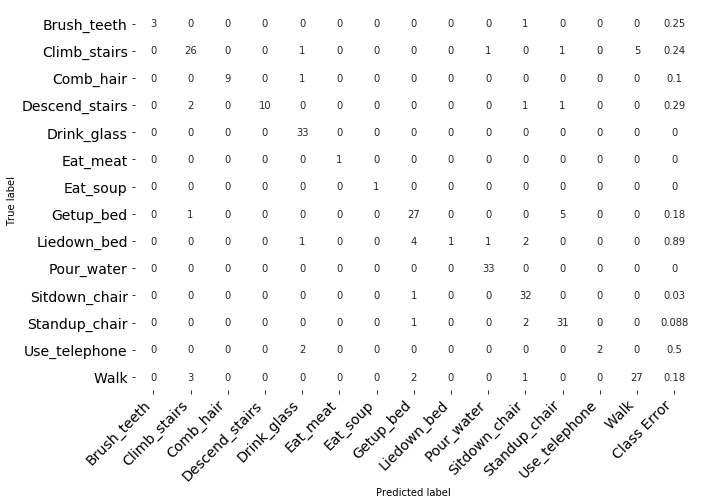

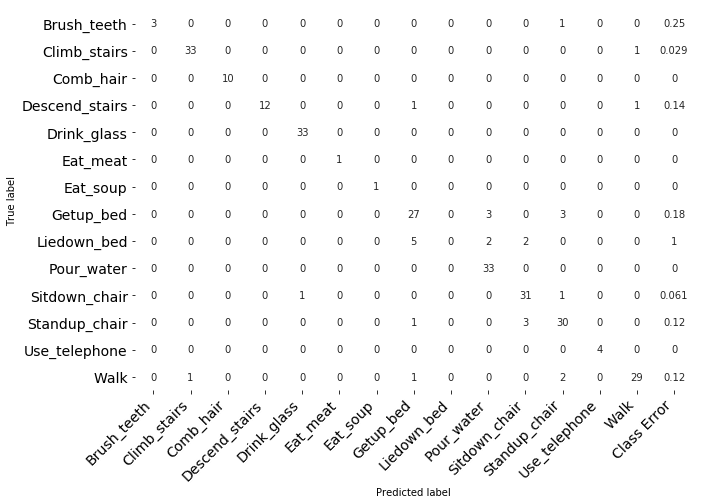

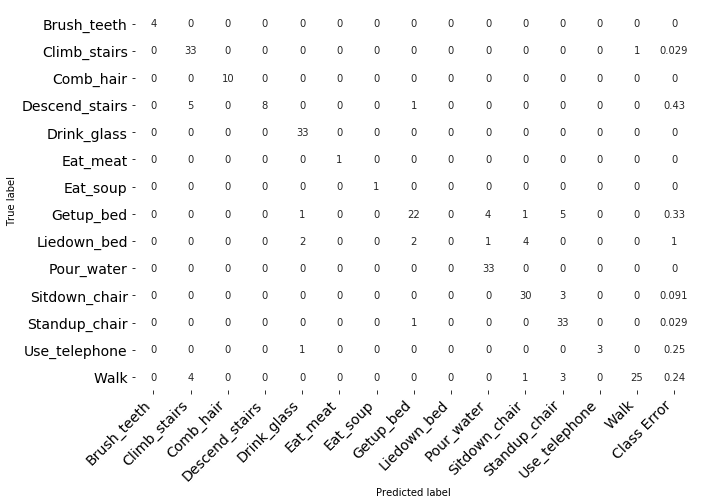

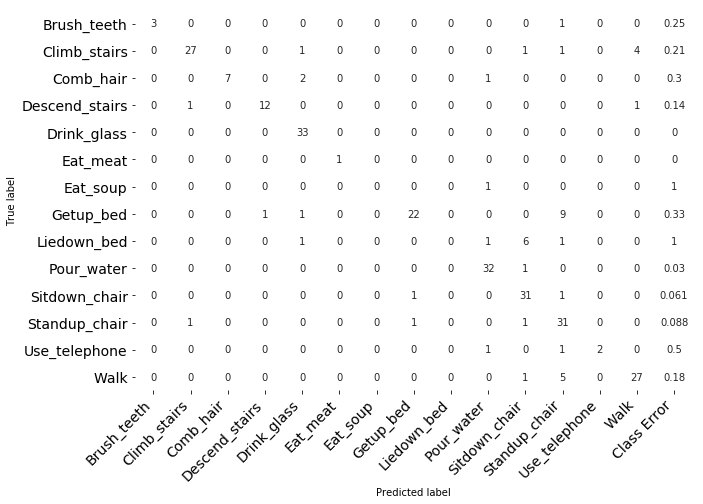

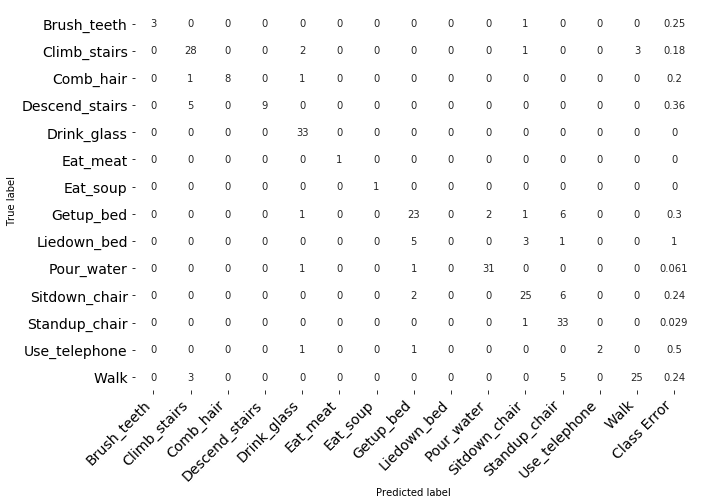

In [12]:
k_experiments = (200, 480, (32, 15), (40, 12), (15, 8, 4))
for k_val in k_experiments:
  print("k_val: {}".format(k_val))
  km = h_kmeans(k_val, n_jobs=-1).fit(dictionary)
  hist_points, class_labels = get_histograms(km, dataset, np.prod(k_val), slice_size)
  y_predicted, y_label = measure_accuracy_with_folding(hist_points, class_labels)
  cm = confusion_matrix(y_label, y_predicted)
  out = print_confusion_matrix(cm, labels)


# Appendix

## Confusion Matrix

In [11]:
from matplotlib.colors import ListedColormap
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), 
                           fontsize=14):
    """Prints a confusion matrix, as returned by 
    sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to 
        sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index 
        the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal 
        size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    classErrors = []
    for i in range(len(df_cm)):
      curRow = df_cm.iloc[i]
      error = 1 - (curRow[i] / np.sum(curRow))
      classErrors.append(error)
    classErrors = np.array(classErrors)
    df_cm['Class Error'] = classErrors
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, cbar=False, 
                              cmap=ListedColormap(['white']))
        #fmt="d"
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                 rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                 rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## Sliding Window